This is a test of the "Plan A" to:

* Use PHAT to do target selection
* Compare to the NIRCam pre-imaging to look for outliers
* Select MSATA stars and targets only where the two match up

In [1]:
import math
from pathlib import Path
import json

import numpy as np
from scipy import optimize

from astropy.table import QTable, Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import visualization as aviz

from astropy import units as u

import jwst.datamodels

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
phat_tab = QTable.read('hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12110-m31-b19_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits')
phat_tab['coord'] = SkyCoord.guess_from_table(phat_tab, unit='deg')
phat_tab

<QTable length=4032306>
   x       y            ra                dec         f110w_rate ... inside_ir inside_brick inside_chipgap inside_other_chipgap                 coord                
                                                                 ...                                                                           deg,deg               
float32 float32      float64            float64        float32   ...    bool       bool          bool              bool                        SkyCoord              
------- ------- ------------------ ------------------ ---------- ... --------- ------------ -------------- -------------------- -------------------------------------
 2594.8 3361.66 11.580036786094919 42.088067163048244    6.5e-06 ...      True         True          False                False 11.580036786094919,42.088067163048244
2726.61 1923.46 11.603287760928435 42.098294951116664      1e-06 ...      True         True          False                False 11.603287760928435,42.098294951116664
1228.87 2331.91 11.580653944770967  42.11181945656603   8.82e-07 ...      True         True          False                False  11.580653944770967,42.11181945656603
2332.32 3502.88 11.575015071160772 42.089869674165655   6.19e-07 ...      True         True          False                False 11.575015071160772,42.089869674165655
 2021.7  532.24 11.616652426284764 42.117551579875084   2.29e-07 ...      True         True          False                False 11.616652426284764,42.117551579875084
    ...     ...                ...                ...        ... ...       ...          ...            ...                  ...                                   ...
3413.43 2029.18 11.340403167029407  42.07303051463705   9.23e-12 ...      True         True          False                False  11.340403167029407,42.07303051463705
2372.74 2491.61 11.358861977332113 42.065138230803846   -2.4e-12 ...      True         True          False                False 11.358861977332113,42.065138230803846
 2181.4 2481.15 11.360812348237896  42.06290577671855   5.58e-11 ...      True         True          False                False  11.360812348237896,42.06290577671855
1617.15 2564.03  11.36828162362711  42.05725244364644   -7.5e-11 ...      True         True          False                False   11.36828162362711,42.05725244364644
 1796.2 3196.38  11.37586585399751 42.064433537886416   3.93e-11 ...      True         True          False                False  11.37586585399751,42.064433537886416

In [3]:
with open('phat_astrom_correction.json') as f:
    phat_astrom_correction = json.load(f)
phat_astrom_correction

{'description': 'offsets to add to the phat catalog to put it on the Gaia DR3 frame',
 'ra_to_add_to_phat_deg': 3.318070797497796e-05,
 'dec_to_add_to_phat_deg': -5.023828265393604e-06}

In [4]:
phat_tab['coord_corr'] = SkyCoord(
    ra=phat_tab['coord'].ra + phat_astrom_correction['dec_to_add_to_phat_deg']*u.deg, 
    dec=phat_tab['coord'].dec + phat_astrom_correction['dec_to_add_to_phat_deg']*u.deg
)

# MSATA stars

Now select some candidate MSATA stars.  Limits (next cell) are taken from PHAT_msata_tests.ipynb

In [5]:
## E's values from running ETC for M32 catalog (optical filters)
#saturation_limit = 19.2 # according to ETC in F110W with NSRAPID  #vegamag is 19.2 abmag is 19.5
#faint_limit = 23.2 # S/N > 20 in F110W with NSRAPID # vegamag is 23.2 abmag is 23.5
#companion_mag_cutoff = 26

# K's values from running ETC for PHAT catalog
saturation_limit = 19.0 # according to ETC - source mag in vegamag F110W WFC3/IR, strategy: with NSRAPID in F110W
# using JDOX table - this is a more conservative choice
saturation_limit = 19.5 

faint_limit = 22.1 # S/N > 20 according to ETC; vegamag F110W WFC3/IR, with NSRAPID in F110W
# unlike saturation limit, above is approx. the same as the JDOX table, which is 22.0 in F110W NIRSpec
faint_limit_for_mag_contrast = faint_limit + 2  # this *must* be fainter than faint_limit for the code below to work right
companion_mag_cutoff = faint_limit + 10.  # this is for determining what counts when looking for companions within 0.3 arcsec

flux_factor_for_contrast = 10**((faint_limit_for_mag_contrast - faint_limit)/-2.5)


In [6]:
# "gst" field is true for good stars
msata_candidates = phat_tab[(saturation_limit < phat_tab['f110w_vega'])&(phat_tab['f110w_vega'] < faint_limit)&phat_tab['f110w_gst']]
len(msata_candidates)

71896

In [7]:
msata_candidates

<QTable length=71896>
   x       y            ra                dec         ... inside_chipgap inside_other_chipgap                coord                               coord_corr             
                                                      ...                                                   deg,deg                               deg,deg               
float32 float32      float64            float64       ...      bool              bool                       SkyCoord                              SkyCoord              
------- ------- ------------------ ------------------ ... -------------- -------------------- ------------------------------------ -------------------------------------
2900.36 1709.48 11.608439093401586  42.09808189962843 ...          False                False 11.608439093401586,42.09808189962843   11.60843406957332,42.09807687580017
1274.38 2450.39 11.579357043152323  42.11034257945481 ...          False                False 11.579357043152323,42.11034257945481  11.579352019324057,42.11033755562654
 588.07 2379.91  11.57288936661742 42.118636919402036 ...          False                False 11.57288936661742,42.118636919402036  11.572884342789155,42.11863189557377
1643.49 1407.11 11.599230858037894  42.11468535713878 ...          False                False 11.599230858037894,42.11468535713878  11.599225834209628,42.11468033331052
3270.71 2480.46 11.600812709803572  42.08763835176113 ...          False                False 11.600812709803572,42.08763835176113  11.600807685975306,42.08763332793286
    ...     ...                ...                ... ...            ...                  ...                                  ...                                   ...
 655.58 3718.68 11.396323083529229  42.05590348080689 ...          False                 True 11.396323083529229,42.05590348080689 11.396318059700963,42.055898456978625
1363.54 1443.07  11.35413858527302 42.045237085196675 ...          False                False 11.35413858527302,42.045237085196675  11.354133561444755,42.04523206136841
 1503.9 3903.99 11.389781658468646  42.06693964978838 ...          False                 True 11.389781658468646,42.06693964978838  11.38977663464038,42.066934625960116
1324.47 3779.87 11.389881700847676   42.0639110137578 ...          False                 True  11.389881700847676,42.0639110137578   11.38987667701941,42.06390598992954
 970.38 3855.19  11.39491992565061  42.06055275719167 ...          False                 True  11.39491992565061,42.06055275719167  11.394914901822345,42.06054773336341

In [8]:
f150w_image_dir = Path('MAST_2022-08-24T1111/JWST/jw02609-o001_t006_nircam_clear-f150w/')
i2ds = list(f150w_image_dir.glob('*i2d.fits*'))
assert len(i2ds) == 1
i2d_path = i2ds[0]

In [9]:
i2d_img = jwst.datamodels.open(i2d_path)
i2d_img

<ImageModel(9383, 11552) from jw02609-o001_t006_nircam_clear-f150w_i2d.fits>

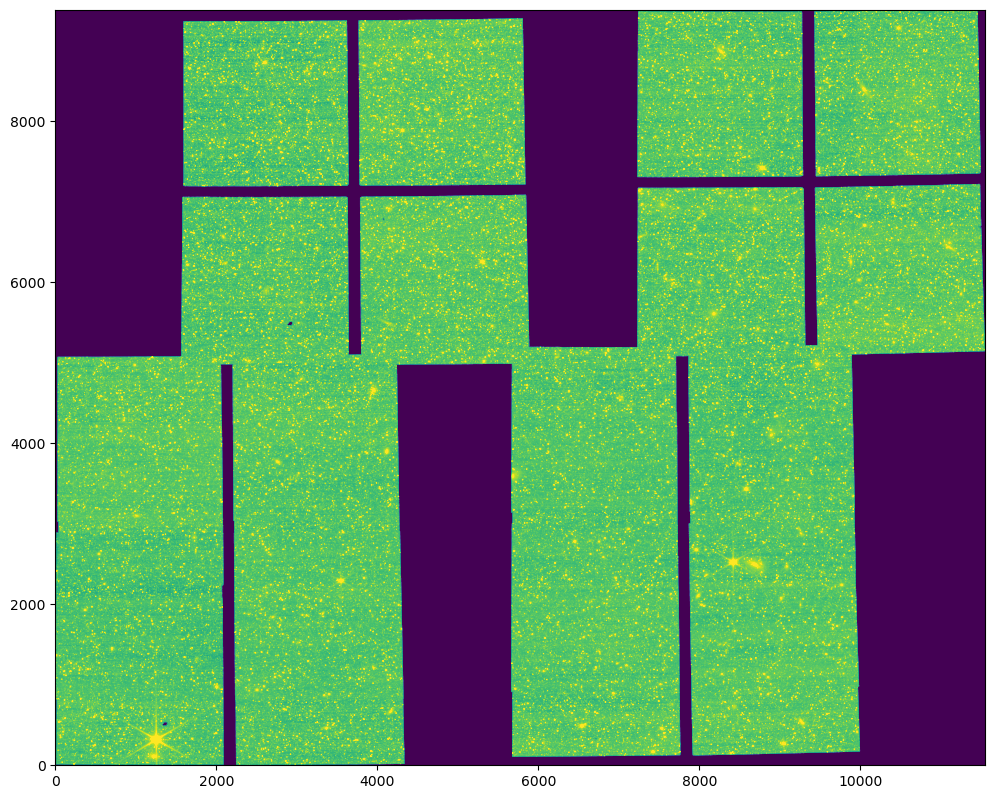

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch());

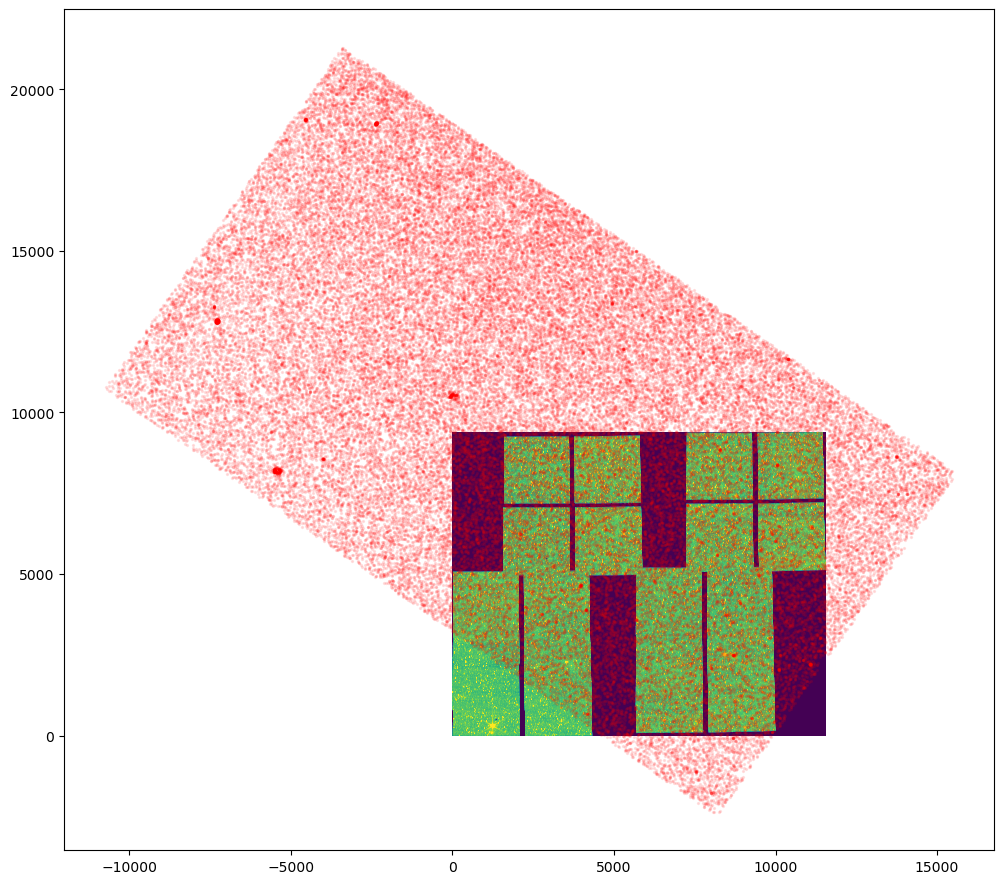

In [11]:
x_cand, y_cand = i2d_img.meta.wcs.world_to_pixel(msata_candidates['coord_corr'])
ax.scatter(x_cand, y_cand,alpha=.1, s=2, c='r')

fig

Need to filter out anything where the pixel is off the footprint

In [12]:
in_footprint = (0 < x_cand) & (x_cand < i2d_img.shape[1]) & (0 < y_cand) & (y_cand < i2d_img.shape[0])

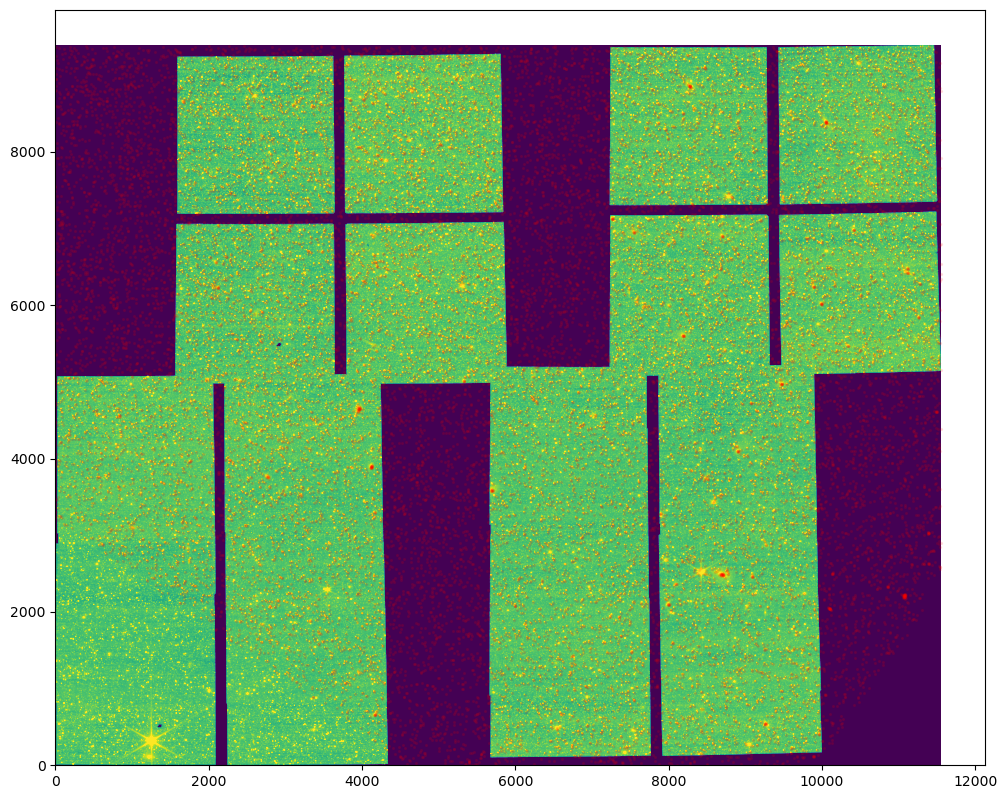

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch());
ax.scatter(x_cand[in_footprint], y_cand[in_footprint], alpha=.1, s=2, c='r')

Now try doing aperture photometry on the preimage and compare to the phat mags

In [14]:
from photutils import aperture

In [15]:
aps = aperture.CircularAperture(np.array([x_cand, y_cand]).T[in_footprint], r=5) 
phot = aperture.aperture_photometry(i2d_img.data, aps)
phot['mag'] = -2.5*np.log10(phot['aperture_sum'])
phot

2022-10-10 14:09:43,952 - stpipe - WARNING - /tmp/ipykernel_40030/3830932961.py:3: RuntimeWarning: divide by zero encountered in log10
  phot['mag'] = -2.5*np.log10(phot['aperture_sum'])



<QTable length=22244>
  id       xcenter            ycenter          aperture_sum            mag        
             pix                pix                                               
int64      float64            float64            float64             float64      
----- ------------------ ------------------ ------------------ -------------------
    1  6584.573342199723  685.4860106117171 1867.2562928399611  -8.178009829322386
    2 5510.9962920895305  376.0600177113274                0.0                 inf
    3  9757.636153427113 1306.7432438759356 1341.0450967621853  -7.818608456459081
    4   7538.60751365501  2365.840571647383 1003.0953391708484  -7.503355531225184
    5  7456.372571820348  3120.009295883097  887.2914369221387  -7.370165725618021
  ...                ...                ...                ...                 ...
22240   6985.10486091218  9093.706585159016                0.0                 inf
22241 7789.8081746864245  9278.582286591165  37.23303335669564 -3.9273210485375443
22242  7495.559002147131  8991.314428829453  50.17818818114022   -4.25128743971936
22243 7610.0749666961965  9273.649382593394  39.52203289280047 -3.9920981881833955
22244  6947.093855861364  8988.131405731157                0.0                 inf

(18.0, 23.0)

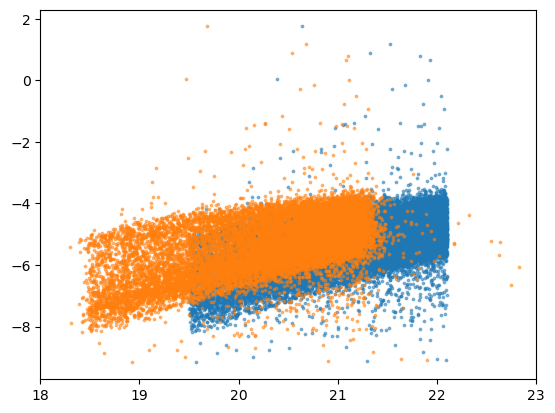

In [16]:
plt.scatter(msata_candidates['f110w_vega'][in_footprint],  phot['mag'], s=3, alpha=.5)
plt.scatter(msata_candidates['f160w_vega'][in_footprint],  phot['mag'], s=3, alpha=.5)
plt.xlim(18, 23)

OK that's clearly wrong.  Lets look at some of them more closely

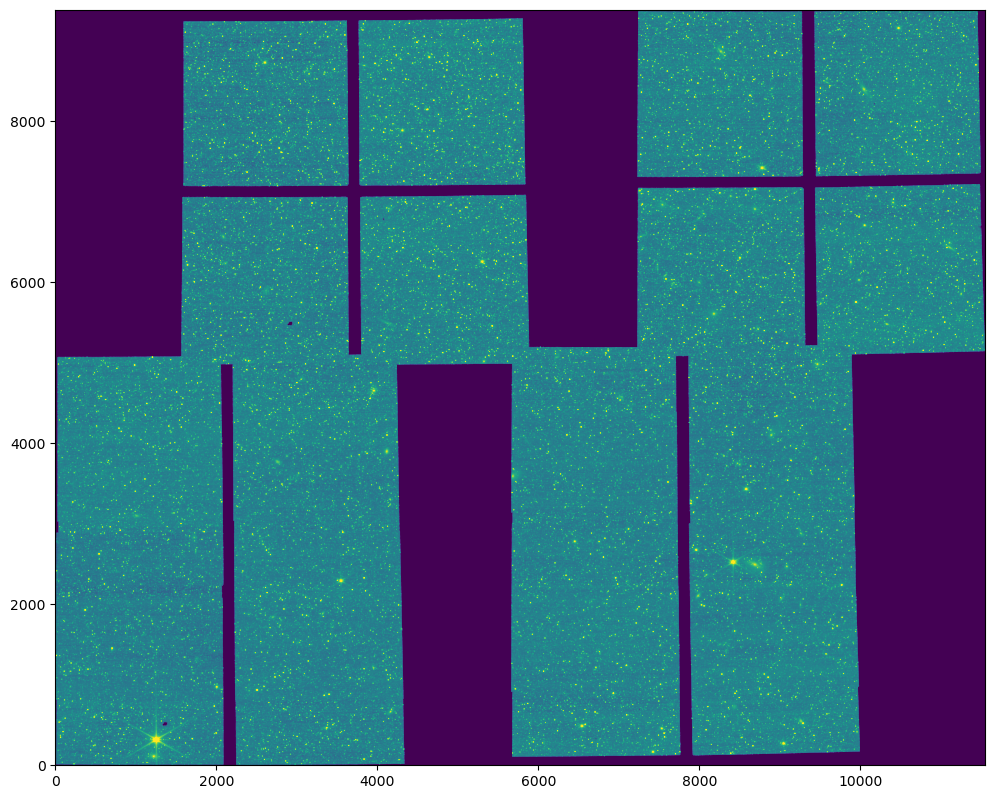

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                 interval=aviz.AsymmetricPercentileInterval(1, 99.9),
                stretch=aviz.LogStretch());

Aperture: CircularAperture
positions: [1509.43311634, 3174.65691119]
r: 5.0


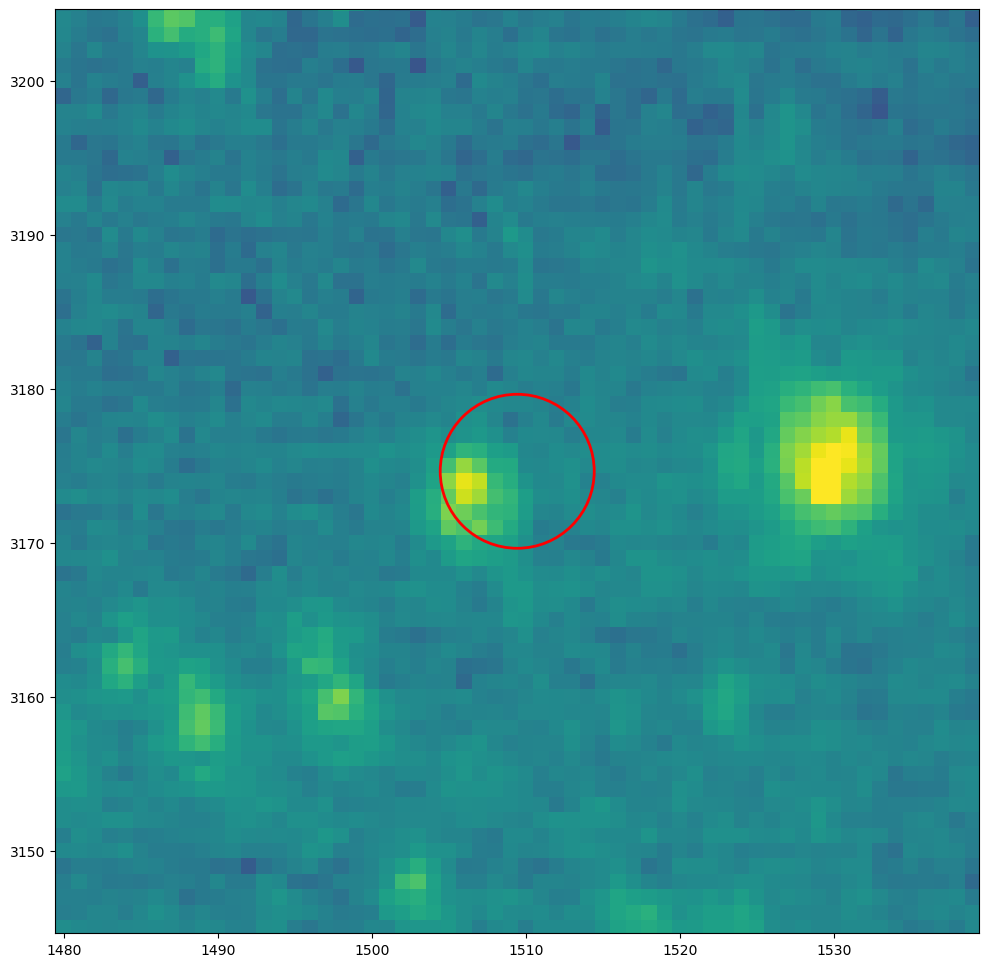

<Figure size 640x480 with 0 Axes>

In [20]:
ap = aps[np.random.randint(len(aps))]
ap.plot(ax, color='red', lw=2)
ax.set_xlim(ap.positions[0]-30, ap.positions[0]+30)
ax.set_ylim(ap.positions[1]-30, ap.positions[1]+30)
plt.savefig('offset_apphot.png')
print(ap)
fig

# Try comparing with Charlie's catalog

In [30]:
nircam150_tab = Table.read('150w-simple-cat.fits')
nircam150_tab['coord'] = SkyCoord(nircam150_tab['ra_corr'], nircam150_tab['dec_corr'])
nircam150_tab

<Table length=263306>
        ra                dec              ra_corr            dec_corr            psfmag            cal_mag                       coord                
       deg                deg                deg                deg                                                              deg,deg               
     float64            float64            float64            float64            float64            float64                      SkyCoord              
------------------ ------------------ ------------------ ------------------ ------------------ ------------------ -------------------------------------
11.549935797573058  42.13940934180434 11.550021908684169  42.13939545291545  22.53758616094166  23.15385199775311  11.550021908684169,42.13939545291545
11.550617706170984 42.138921273207075 11.550703817282095  42.13890738431819   22.3685875612084  22.98485339801985  11.550703817282095,42.13890738431819
11.549858486346341  42.13945228501548 11.549944597457452  42.13943839612659 21.678337967011554 22.294603803823005  11.549944597457452,42.13943839612659
  11.5501912109507   42.1391873397452 11.550277322061811  42.13917345085631 23.563603741350803 24.179869578162254  11.550277322061811,42.13917345085631
11.551450953333326   42.1383063850018 11.551537064444437  42.13829249611291  21.92637686196244  22.54264269877389  11.551537064444437,42.13829249611291
               ...                ...                ...                ...                ...                ...                                   ...
11.549014943087947  42.02872265856961 11.549101054199058 42.028708769680726  19.96339062122452  20.57965645803597 11.549101054199058,42.028708769680726
11.549231410197956  42.02854902110785 11.549317521309067  42.02853513221896 21.209457947842942 21.825723784654393  11.549317521309067,42.02853513221896
11.550216792638777 42.027772835117645 11.550302903749888  42.02775894622876 21.602286534623587 22.218552371435038  11.550302903749888,42.02775894622876
 11.54953053978766 42.028228495818226 11.549616650898772  42.02821460692934 21.497624043728255 22.113889880539706  11.549616650898772,42.02821460692934
11.549802479706397  42.02803532355763 11.549888590817508 42.028021434668744  21.65458340380426  22.27084924061571 11.549888590817508,42.028021434668744

In [31]:
idx, sep, _ = msata_candidates[in_footprint]['coord_corr'].match_to_catalog_sky(nircam150_tab['coord'])

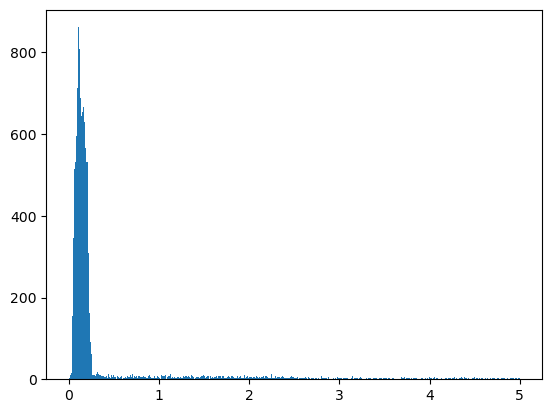

In [32]:
plt.hist(sep.arcsec, bins='auto', range=(0, 5));

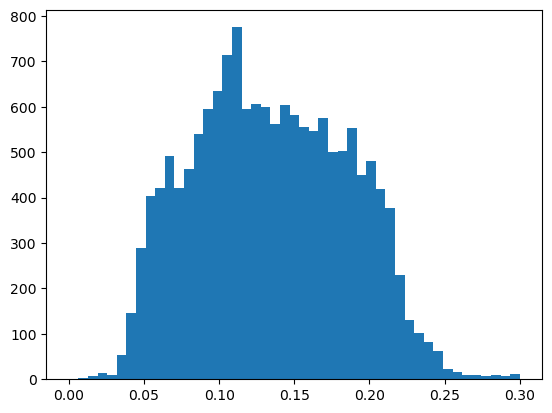

In [33]:
plt.hist(sep.arcsec, bins='auto', range=(0, .3));

Text(0, 0.5, 'ddec [PHAT vs nircam]')

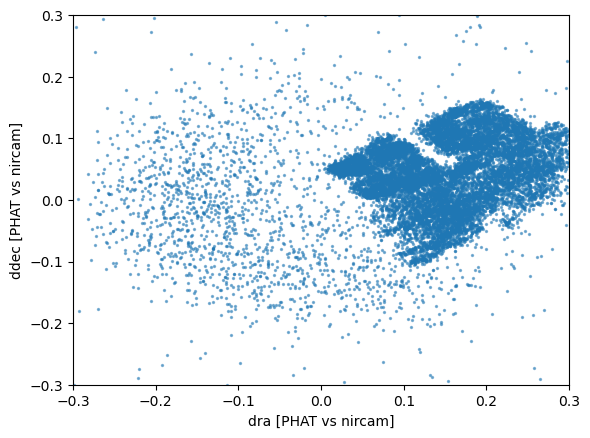

In [34]:
dra = (nircam150_tab['coord'][idx].ra - msata_candidates[in_footprint]['coord_corr'].ra).to(u.arcsec)
ddec = (nircam150_tab['coord'][idx].dec - msata_candidates[in_footprint]['coord_corr'].dec).to(u.arcsec)
plt.scatter(dra, ddec, s=2, alpha=.5)
plt.xlim(-.3, .3)
plt.ylim(-.3, .3)

plt.xlabel('dra [PHAT vs nircam]')
plt.ylabel('ddec [PHAT vs nircam]')

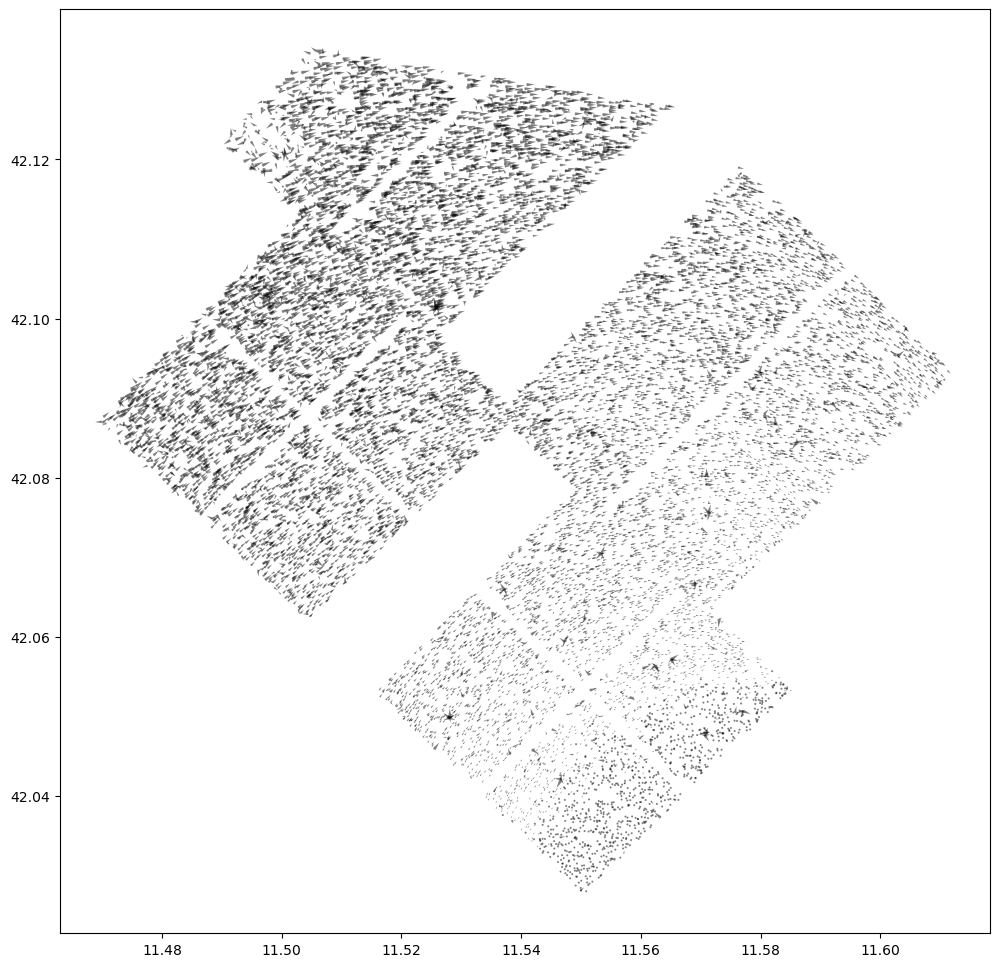

In [35]:
msk = np.hypot(dra,ddec) < .3*u.arcsec

plt.figure(figsize=(12, 12))
plt.quiver(nircam150_tab['coord'][idx].ra.value[msk], 
           nircam150_tab['coord'][idx].dec.value[msk], 
           dra.value[msk], ddec.value[msk], alpha=.5, headwidth=2, scale=.3*100)

plt.savefig('match_residuals.png')

## Try the second version of charlie's catalog

In [43]:
ls *fits

150w-simple-cat.fits
hlsp_phat_hst_acs-wfc_12110-m31-b19-f01_f475w_v1_drz.fits
hlsp_phat_hst_acs-wfc_12110-m31-b19-f01_f814w_v1_drz.fits
hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12110-m31-b19_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits
NIRCAM-F150W-Prometheus-magcal-gaiacal.fits


In [44]:
nircam150_tab2 = Table.read('NIRCAM-F150W-Prometheus-magcal-gaiacal.fits')
nircam150_tab2['coord'] = SkyCoord(nircam150_tab2['ra'], nircam150_tab2['dec'])
nircam150_tab2

<Table length=263306>
  id           thresh         npix tnpix  xmin  xmax ...        dec               ra_new            dec_new             F150W                        coord                
                                                     ...        deg                                                                                 deg,deg               
int64         float64        int64 int64 int64 int64 ...      float64            float64            float64            float64                      SkyCoord              
------ --------------------- ----- ----- ----- ----- ... ------------------ ------------------ ------------------ ------------------ -------------------------------------
     1   0.20459017157554626    15    11  2362  2367 ...  42.13940934180434 11.549971801440986  42.13939950431407  23.15385199775311  11.549935797573058,42.13940934180434
     2   0.20555515587329865    14     8  2444  2448 ... 42.138921273207075 11.550656877513957  42.13890993757956  22.98485339801985 11.550617706170984,42.138921273207075
     3    0.2011030912399292    33    27  2354  2360 ...  42.13945228501548 11.549897880915438  42.13944244444909 22.294603803823005  11.549858486346341,42.13945228501548
     4    0.1967414915561676    11     7  2397  2400 ...   42.1391873397452 11.550238220751769  42.13918156791779 24.179869578162254     11.5501912109507,42.1391873397452
     5   0.19982442259788513    28    18  2543  2548 ...   42.1383063850018 11.551493030571748  42.13830070819258  22.54264269877389   11.551450953333326,42.1383063850018
   ...                   ...   ...   ...   ...   ... ...                ...                ...                ...                ...                                   ...
263302 1.500000098129063e+30   237     0 11130 11148 ...  42.02872265856961  11.54913977414912 42.028696633148954  20.57965645803597  11.549014943087947,42.02872265856961
263303 1.500000098129063e+30   211     0 11158 11176 ...  42.02854902110785 11.549335165335378  42.02851922916641 21.825723784654393  11.549231410197956,42.02854902110785
263304    0.2214955985546112    28    21 11289 11294 ... 42.027772835117645 11.550344152777855 42.027742475518195 22.218552371435038 11.550216792638777,42.027772835117645
263305 1.500000098129063e+30    26     0 11210 11216 ... 42.028228495818226 11.549660434634728  42.02820152175903 22.113889880539706  11.54953053978766,42.028228495818226
263306 1.500000098129063e+30    57     0 11240 11249 ...  42.02803532355763 11.549937220874494  42.02801309158033  22.27084924061571  11.549802479706397,42.02803532355763

In [45]:
idx, sep, _ = msata_candidates[in_footprint]['coord_corr'].match_to_catalog_sky(nircam150_tab2['coord'])

Text(0, 0.5, 'ddec [PHAT vs nircam]')

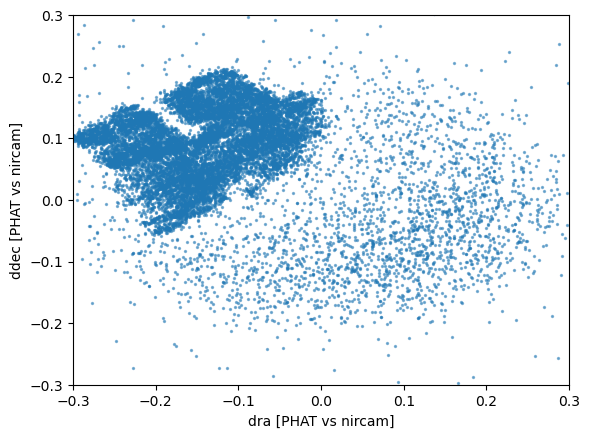

In [46]:
dra = (nircam150_tab2['coord'][idx].ra - msata_candidates[in_footprint]['coord_corr'].ra).to(u.arcsec)
ddec = (nircam150_tab2['coord'][idx].dec - msata_candidates[in_footprint]['coord_corr'].dec).to(u.arcsec)
plt.scatter(dra, ddec, s=2, alpha=.5)
plt.xlim(-.3, .3)
plt.ylim(-.3, .3)

plt.xlabel('dra [PHAT vs nircam]')
plt.ylabel('ddec [PHAT vs nircam]')

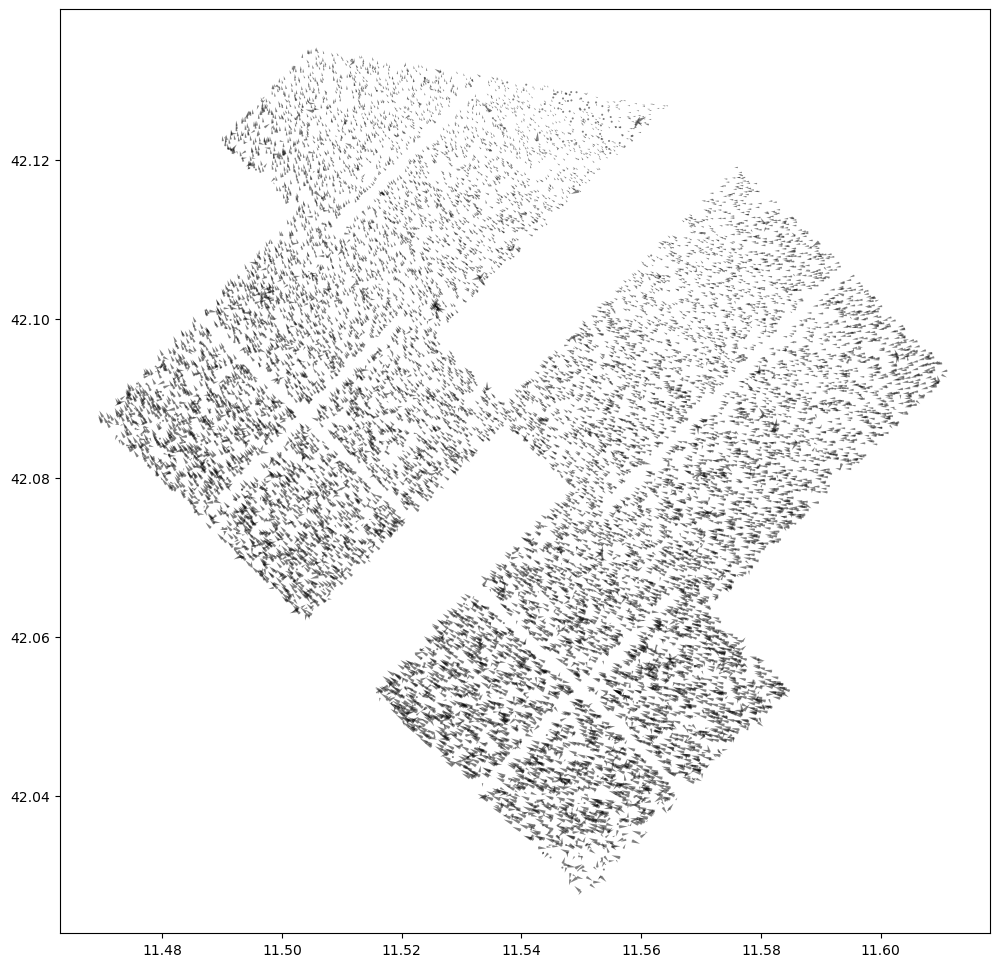

In [47]:
msk = np.hypot(dra,ddec) < .3*u.arcsec

plt.figure(figsize=(12, 12))
plt.quiver(nircam150_tab2['coord'][idx].ra.value[msk], 
           nircam150_tab2['coord'][idx].dec.value[msk], 
           dra.value[msk], ddec.value[msk], alpha=.5, headwidth=2, scale=.3*100)

plt.savefig('match_residuals2.png')